In [ ]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import numpy as np
from numpy import exp, sqrt, log, pi, arctan
from scipy.optimize import curve_fit 
from scipy.stats import chi2
from glob import glob
from astropy.io import fits
from astropy.visualization import simple_norm
import matplotlib.patches as mpatches
import statistics as st
import pandas as pd
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d

def fehler(name, G, sig_G, G_lit, sig_G_lit):
    print(name)
    print('Relative error: ', sig_G / G * 100)
    print('Rel. error (comparison):', sig_G_lit / G_lit * 100)
    print('Absolute error: ', G - G_lit)
#    print('Verhältnis:', G / G_lit)
    print('Sigma-deviation: ', np.abs(G - G_lit) / sqrt(sig_G ** 2 
                                                         + sig_G_lit ** 2),'\n')
    
    
def fehler_small(name, G, sig_G):
    print(name)
    print('Relativer Fehler: ', sig_G / G * 100)
    

def result(name, G, sig_G, komma, einheit):
    print(name + ' =', np.round(G, komma), '+/-', np.round(sig_G, komma), einheit)
    

def fitparameter(name, G, sig_G, komma, einheit):
    return name + ' =' + str(np.round(G, komma)) + '$\pm$' + str(np.round(sig_G, komma)) + einheit

def chi_sq(test_func, x_val, y_val, sig_y_val, popt, number):
    chi2_ = np.sum((test_func(x_val, *popt) - y_val) ** 2 
                   / sig_y_val ** 2)
    dof = len(y_val) - number
    chi2_red = chi2_ / dof

    print('chi2 =', chi2_)
    print('chi2_red =',chi2_red)

    prob = np.round(1 - chi2.cdf(chi2_,dof), 2) * 100 
    print('Probability =', prob, '%\n')


BIN[1]

In [1]:
# Original corrector

# Create command to correct the measurements with the underground measurements
def corr(measurement, untergrund):
    '''
    We want to perform the underground correction without having to a) alter the
    data manually and b) making it so that it works for each of the measurements 
    automatically.

    For that we first create a dictionary with keys = wavelengths and 
    items = underground.
    
    The expected "elegant solution" is somehow still overly complicated and 
    surely very inefficient.
    '''
    
    untergrund_0, untergrund_1, untergrund_2, untergrund_3 = data(untergrund)
    
    # Filter out measurements from second run
    
    one_first = np.where(untergrund_0 == 1)[0][0] 
    one_last = np.where(untergrund_0 == 1)[0][-1] + 1 
    ''' + 1 because for some reason
    it stops too soon'''
    
    untergrund_0 = untergrund_0[one_first:one_last]
    untergrund_1 = untergrund_1[one_first:one_last]
    untergrund_2 = untergrund_2[one_first:one_last]
    untergrund_3 = untergrund_3[one_first:one_last]
    
    # Create dictionary of wavelength: underground
    
    unt_dict = {}
    
    for i in range(len(untergrund_0)):
        unt_dict.update({untergrund_2[i] : untergrund_3[i]})
    
    # Subtract the underground from the measurement

    data_0, data_1, data_2, data_3 = data(measurement)
    
    meas_dict = {}
    meas_dict_std = np.array([])
    
    for i in range(len(data_0)):
        meas_dict.update({data_2[i]:np.array([])})
    
    for i in range(len(data_0)):
        meas_dict[data_2[i]] = np.append(meas_dict[data_2[i]], data_3[i])

     # From every measurement, take the mean value
            
    for key in meas_dict:    
        meas_dict_std = np.append(meas_dict_std, np.std(meas_dict.get(key)))
    
        meas_dict.update({key:meas_dict.get(key) - unt_dict.get(key)})
        meas_dict.update({key:np.mean(meas_dict.get(key))})
        
    

    corr_data, std_data = np.array([*meas_dict.items()]), meas_dict_std
    '''
    In the first column, there is the wavelength, and in the second one is
    the associated intensity
    '''
    
    return corr_data, std_data

In [ ]:
# Saved data
data_O2 = corr('O2', 'O2-Untergrund')
data_H2 = corr('H2', 'H2-Untergrund')
data_N2 = corr('N2', 'N2-Untergrund')
data_D2 = corr('D2', 'D2-Untergrund')
data_Para = corr('Para', 'Para-Untergrund')

BIN[2]

In [ ]:
# Create command to specifically correct the measurement of para-H2
def corr_Para(measurement, untergrund, a, b):
    '''
    The difference between the para-measurement, is that it is ultra long, 
    and pure para-H2 is only present for a portion of the measurement.
    The Para correction here takes only specific scans, e.g. from
    data points 0 * 91:6 * 91 and spits out the mean of the first 6 scans
    '''
    
    untergrund_0, untergrund_1, untergrund_2, untergrund_3 = data(untergrund)
    
    # Filter out measurements from second run
    
    one_first = np.where(untergrund_0 == 1)[0][0] 
    one_last = np.where(untergrund_0 == 1)[0][-1] + 1 
    ''' + 1 because for some reason
    it stops too soon'''
    
    untergrund_0 = untergrund_0[one_first:one_last]
    untergrund_1 = untergrund_1[one_first:one_last]
    untergrund_2 = untergrund_2[one_first:one_last]
    untergrund_3 = untergrund_3[one_first:one_last]
    
    # Create dictionary of wavelength: underground
    
    unt_dict = {}
    
    for i in range(len(untergrund_0)):
        unt_dict.update({untergrund_2[i] : untergrund_3[i]})
    
    # Subtract the underground from the measurement

    data_0, data_1, data_2, data_3 = data(measurement)
    
    meas_dict = {}
    meas_dict_std = np.array([])
    
    for i in np.arange(a * 91, b * 91, 1):#range(len(data_0[a * 91:b * 91])):
        meas_dict.update({data_2[i]:np.array([])})
    
    for i in np.arange(a * 91, b * 91, 1):#range(len(data_0[a * 91:b * 91])):
        meas_dict[data_2[i]] = np.append(meas_dict[data_2[i]], data_3[i])

     # From every measurement, take the mean value
            
    for key in meas_dict:    
        meas_dict_std = np.append(meas_dict_std, np.std(meas_dict.get(key)))
    
        meas_dict.update({key:meas_dict.get(key) - unt_dict.get(key)})
        meas_dict.update({key:np.mean(meas_dict.get(key))})
        
    

    corr_data, std_data = np.array([*meas_dict.items()]), meas_dict_std
    '''
    In the first column, there is the wavelength, and in the second one is
    the associated intensity
    '''
    
    return corr_data, std_data

data_Para_corr = corr_Para('Para', 'Para-Untergrund', 0, 6)

BIN[3]

In [ ]:
# Results
amp_H2_a = fit_H2_ab[0][0]
err_amp_H2_a = sqrt(fit_H2_ab[1][0, 0])
lambda_H2_a = fit_H2_ab[0][1]
err_lambda_H2_a = sqrt(fit_H2_ab[1][1, 1])

amp_H2_b = fit_H2_ab[0][3]
err_amp_H2_b = sqrt(fit_H2_ab[1][3, 3])
lambda_H2_b = fit_H2_ab[0][4]
err_lambda_H2_b = sqrt(fit_H2_ab[1][4, 4])

amp_H2_c = fit_H2_c[0][0]
err_amp_H2_c = sqrt(fit_H2_c[1][0, 0])
lambda_H2_c = fit_H2_c[0][1]
err_lambda_H2_c = sqrt(fit_H2_c[1][1, 1])

amp_H2_d = fit_H2_d[0][0]
err_amp_H2_d = sqrt(fit_H2_d[1][0, 0])
lambda_H2_d = fit_H2_d[0][1]
err_lambda_H2_d= sqrt(fit_H2_d[1][1, 1])


# Outputs


props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr_02 = fitparameter('$\lambda_{H2,\,0\\to2}$', lambda_H2_a, 
                          err_lambda_H2_a, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{H2,\,0\\to2}$', amp_H2_a, err_amp_H2_a, 0, ' [s$^{-1}$]')

textstr_13 = fitparameter('$\lambda_{H2,\,1\\to3}$', lambda_H2_b, 
                          err_lambda_H2_b, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{H2,\,1\\to3}$', amp_H2_b, err_amp_H2_b, 0, ' [s$^{-1}$]')

textstr_24 = fitparameter('$\lambda_{H2,\,2\\to4}$', lambda_H2_c, 
                          err_lambda_H2_c, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{H2,\,2\\to4}$', amp_H2_c, err_amp_H2_c, 0, ' [s$^{-1}$]')

textstr_35 = fitparameter('$\lambda_{H2,\,3\\to5}$', lambda_H2_d, 
                          err_lambda_H2_d, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{H2,\,3\\to5}$', amp_H2_d, err_amp_H2_d, 0, ' [s$^{-1}$]')


                       
plt.text(565, 400, textstr_02 + '\n\n' + textstr_13 + '\n\n' + textstr_24
         + '\n\n' + textstr_35, 
         fontsize = 14, verticalalignment = 'top', bbox = props)

plt.text(540, 320, '$\dfrac{I_{1 \\to 3}}{I_{0 \\to 2}}=$' + str(np.round(amp_H2_b/amp_H2_a,2)),
         fontsize = 14, verticalalignment = 'top', bbox = props)



# a
plt.text(fit_H2_ab[0][1] - 1, - 40, '$0 \\to 2$', fontsize = 14)
plt.text(fit_H2_ab[0][4] - 1, - 40, '$1 \\to 3$', fontsize = 14)
plt.text(fit_H2_c[0][1] - 1, - 40, '$2 \\to 4$', fontsize = 14)
plt.text(fit_H2_d[0][1] - 1, - 40, '$3 \\to 5$', fontsize = 14)

plt.savefig('diagrams/Raman_Spektrum_H2.png')


# Save the relevant fitparameters
lambdas_H2 = np.array([lambda_H2_a, lambda_H2_b, lambda_H2_c, lambda_H2_d])
err_lambdas_H2 = np.array([err_lambda_H2_a, err_lambda_H2_b, err_lambda_H2_c,
                          err_lambda_H2_d])

BIN[4]: Test-Para

Test: Relation of o to p in running mean measurement

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


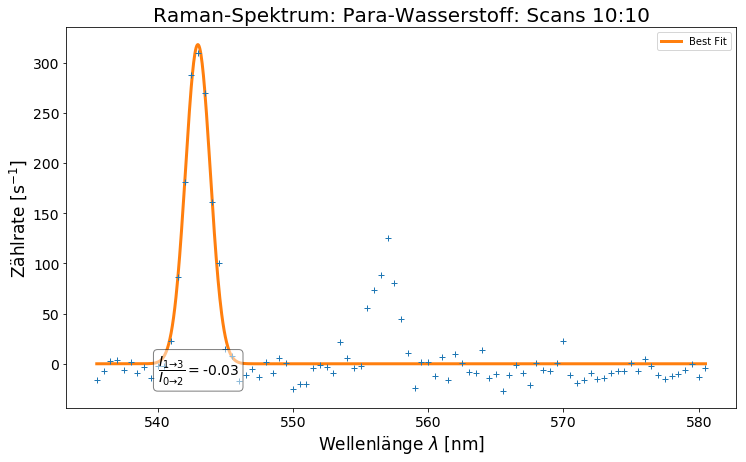

In [311]:
a = 10
b = 10
data_para_ab = corr_data_pd_ab('Para', 'Para-Untergrund', a, b)
data_para_ab_rm = data_para_ab[0], uniform_filter1d(data_para_ab[1], size = N), data_para_ab[2]


fit_para_ab = fitter('Para-Wasserstoff: Scans ' + str(a) + ':' + str(b), 
                     data_para_ab, double_gaussian, p0_H2_double, 'Best Fit')
#fit_para_ab_rm = fitter('Para-Wasserstoff: Scans ' + str(a) + ':' + str(b), 
 #                    data_para_ab_rm, double_gaussian, p0_H2_double, 'Best Fit')

amp_H2_a = fit_para_ab[0][0]
amp_H2_b = fit_para_ab[0][3]


plt.text(540, 10, '$\dfrac{I_{1 \\to 3}}{I_{0 \\to 2}}=$' + str(np.round(amp_H2_b/amp_H2_a,2)),
         fontsize = 14, verticalalignment = 'top', bbox = props)


plt.savefig('diagrams/Raman_Spektrum_Para_' + str(a) + '_' + str(b) + '.png')

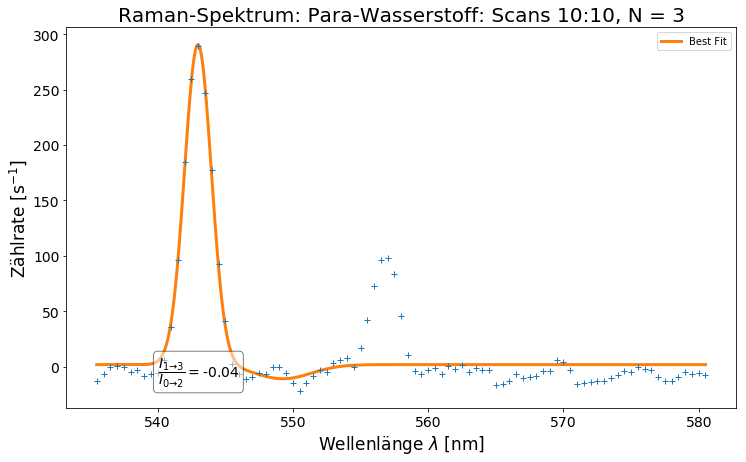

In [312]:
N = 3
data_para_ab_rm = data_para_ab[0], uniform_filter1d(data_para_ab[1], 
                                                    size = N), data_para_ab[2]


fit_para_ab_rm = fitter('Para-Wasserstoff: Scans ' + str(a) + ':' + str(b) 
                        + ', N = ' + str(N), 
                        data_para_ab_rm, double_gaussian, 
                        p0_H2_double, 'Best Fit')

amp_H2_a_rm = fit_para_ab_rm[0][0]
amp_H2_b_rm = fit_para_ab_rm[0][3]


plt.text(540, 10, '$\dfrac{I_{1 \\to 3}}{I_{0 \\to 2}}=$' 
         + str(np.round(amp_H2_b_rm / amp_H2_a_rm,2)),
         fontsize = 14, verticalalignment = 'top', bbox = props)


plt.savefig('diagrams/Raman_Spektrum_Para_' + str(a) + '_' 
            + str(b) + '_rm.png')

BIN[5]

In [ ]:
def para_plotter(para_1, N, fit_func, p0):
    para_1_rm = uniform_filter1d(para_1, size = N)
    
    popt_1, pcov_1 = curve_fit(fit_func, wl_rm, para_1, p0)
    popt_1_rm, pcov_1_rm = curve_fit(fit_func, wl_rm, para_1_rm, p0)
    
    plt.errorbar(wl_rm, para_1, fmt = '.', capsize = 2, label = 'Raw data')
    plt.errorbar(wl_rm, para_1_rm, fmt = '.', capsize = 2, label = 'Running mean, N =' + str(N))
    
    plt.plot(x_lin, fit_func(x_lin, *popt_1), label = 'Fit raw')
    plt.plot(x_lin, fit_func(x_lin, *popt_1_rm), label = 'Fit w/ running mean')
    
    return popt_1, pcov_1, popt_1_rm, pcov_1_rm

data_Para_6 = corr_Para('Para', 'Para-Untergrund', 10, 12)

plt.figure(figsize = (12, 7))
plt.title('Raman-Spektrum: Para-Wasserstoff, Scans: 300-301', size = 20)
plt.xlabel('Wellenlänge $\\lambda$ [nm]', size = 17)
plt.xticks(size = 14)
plt.ylabel('Zählrate $\dot{N}$ [s$^{-1}$]', size = 17)
plt.yticks(size = 14)

data_Para_test = para_plotter(data_Para_6[1], 4, gaussian, 
             p0 = [20, 542.80, 1, 5])

lambda_para_rm = data_Para_test[2][1]
amp_para_rm = data_Para_test[2][0]
lambda_para = data_Para_test[0][1]
amp_para = data_Para_test[0][0]





props = dict(boxstyle='round', facecolor='white', alpha=0.5)

text_str_1 = fitparameter('$\lambda_{rm}$', lambda_para_rm, 
                          0, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{rm}$', amp_para_rm, 0, 0, ' [s$^{-1}$]')

text_str_2 = fitparameter('A[lambda = 543 nm]', data_Para_6[1][13], 0, 4, '[nm]')

plt.text(585, 20, text_str_1 + '\n\n' + text_str_2, fontsize = 14, 
         verticalalignment = 'top', bbox = props)

plt.axvline(542, ls = '--')


plt.legend(loc = 'best')

plt.savefig('diagrams/Para-Wasserstoff_300_300_2.png')

BIN[6]

In [ ]:
p0_H2        = [120, 543.1, 1.8, 0]
p0_H2_double = [120, 543.1, 1.8, 400, 549,    1, 0]
p0_H2_quad   = [120, 542.8, 2,  450, 550.07, 1,   30,  557.53, 3, 20, 565.2, 1, 0]

N = 3
data_H2_rm = data_H2[0], uniform_filter1d(data_H2[1], size = N), data_H2[2]

# Fit
fit_H2_rm = fitter('H2 Running Mean: N = ' + str(N), data_H2_rm, quad_gaussian, p0_H2_quad, 'Best Fit')


# Results
params = fit_H2_rm[0]
err_params = sqrt(np.diag(fit_H2_rm[1]))

amp_H2_a, err_amp_H2_a = params[0], err_params[0]
amp_H2_b, err_amp_H2_b = params[3], err_params[3]
amp_H2_c, err_amp_H2_c = params[6], err_params[6]
amp_H2_d, err_amp_H2_d = params[9], err_params[9]

lambda_H2_a, err_lambda_H2_a = params[1], err_params[1]
lambda_H2_b, err_lambda_H2_b = params[4], err_params[4]
lambda_H2_c, err_lambda_H2_c = params[7], err_params[7]
lambda_H2_d, err_lambda_H2_d = params[10], err_params[10]

lambdas_H2 = np.array([lambda_H2_a, lambda_H2_b, lambda_H2_c, lambda_H2_d])
err_lambdas_H2 = np.array([err_lambda_H2_a, err_lambda_H2_b, err_lambda_H2_c,
                          err_lambda_H2_d])


# Texts
textstr_02 = fitparameter('$\lambda_{H2,\,0\\to2}$', lambda_H2_a, 
                          err_lambda_H2_a, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{H2,\,0\\to2}$', amp_H2_a, err_amp_H2_a, 0, ' [s$^{-1}$]')
textstr_13 = fitparameter('$\lambda_{H2,\,1\\to3}$', lambda_H2_b, 
                          err_lambda_H2_b, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{H2,\,1\\to3}$', amp_H2_b, err_amp_H2_b, 0, ' [s$^{-1}$]')
textstr_24 = fitparameter('$\lambda_{H2,\,2\\to4}$', lambda_H2_c, 
                          err_lambda_H2_c, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{H2,\,2\\to4}$', amp_H2_c, err_amp_H2_c, 0, ' [s$^{-1}$]')
textstr_35 = fitparameter('$\lambda_{H2,\,3\\to5}$', lambda_H2_d, 
                          err_lambda_H2_d, 2, ' [nm]') + '\n' + fitparameter(
    '$A_{H2,\,3\\to5}$', amp_H2_d, err_amp_H2_d, 0, ' [s$^{-1}$]')
                       
plt.text(565, 360, textstr_02 + '\n\n' + textstr_13 + '\n\n' + textstr_24
         + '\n\n' + textstr_35, 
         fontsize = 14, verticalalignment = 'top', bbox = props)

plt.text(params[1] - 1, - 40, '$0 \\to 2$', fontsize = 14)
plt.text(params[4] - 1, - 40, '$1 \\to 3$', fontsize = 14)
plt.text(params[7] - 1, - 40, '$2 \\to 4$', fontsize = 14)
plt.text(params[10] - 1, - 40, '$3 \\to 5$', fontsize = 14)

plt.savefig('diagrams/Raman_Spektrum_H2_rm.png')

BIN[8]

In [ ]:
'''
textstr_02 = fitparameter('$\lambda_{H2,\,0}$', lambda_H2_a, 
                          err_lambda_H2_a, 0, ' [nm]') #+ '\n' + fitparameter(
#    '$A_{H2,\,0}$', amp_H2_a, err_amp_H2_a, 0, ' [s$^{-1}$]')
textstr_13 = fitparameter('$\lambda_{H2,\,1}$', lambda_H2_b, 
                          err_lambda_H2_b, 1, ' [nm]') #+ '\n' + fitparameter(
#    '$A_{H2,\,1}$', amp_H2_b, err_amp_H2_b, 0, ' [s$^{-1}$]')
textstr_24 = fitparameter('$\lambda_{H2,\,2}$', lambda_H2_c, 
                          err_lambda_H2_c, 1, ' [nm]') #+ '\n' + fitparameter(
#    '$A_{H2,\,2}$', amp_H2_c, err_amp_H2_c, 0, ' [s$^{-1}$]')
textstr_35 = fitparameter('$\lambda_{H2,\,3}$', lambda_H2_d, 
                          err_lambda_H2_d, 1, ' [nm]') #+ '\n' + fitparameter(
#    '$A_{H2,\,3}$', amp_H2_d, err_amp_H2_d, 0, ' [s$^{-1}$]')

plt.text(565, 400, textstr_02 + '\n\n' + textstr_13 + '\n\n' + textstr_24
         + '\n\n' + textstr_35, 
         fontsize = 14, verticalalignment = 'top', bbox = props)
         
         
plt.text(params[1] - 1, - 40, '$J = 0$', fontsize = 14)
plt.text(params[4] - 1, - 40, '$J = 1$', fontsize = 14)
plt.text(params[7] - 1, - 40, '$J = 2$', fontsize = 14)
plt.text(params[10] - 1, - 40, '$J = 3$', fontsize = 14)
'''

BIN[9]

In [ ]:
'''
amp_H2_a, err_amp_H2_a = params[0], err_params[0]
amp_H2_b, err_amp_H2_b = params[3], err_params[3]
amp_H2_c, err_amp_H2_c = params[6], err_params[6]
amp_H2_d, err_amp_H2_d = params[9], err_params[9]

c_H2_a, err_c_H2_a = params[2], err_params[2]
c_H2_b, err_c_H2_b = params[5], err_params[5]
c_H2_c, err_c_H2_c = params[8], err_params[8]
c_H2_d, err_c_H2_d = params[11], err_params[11]

lambda_H2_a, err_lambda_H2_a = params[1], 2 * c_H2_a
lambda_H2_b, err_lambda_H2_b = params[4], 2 * c_H2_b
lambda_H2_c, err_lambda_H2_c = params[7], 2 * c_H2_c
lambda_H2_d, err_lambda_H2_d = params[10], 2 * c_H2_d
'''

BIN[10]

In [ ]:
'''
amp_D2_a, err_amp_D2_a = params[0], err_params[0]
amp_D2_b, err_amp_D2_b = params[3], err_params[3]
amp_D2_c, err_amp_D2_c = params[6], err_params[6]

c_D2_a, err_c_D2_a = params[2], err_params[2]
c_D2_b, err_c_D2_b = params[5], err_params[5]
c_D2_c, err_c_D2_c = params[8], err_params[8]

lambda_D2_a, err_lambda_D2_a = params[1], 2 * c_D2_a
lambda_D2_b, err_lambda_D2_b = params[4], 2 * c_D2_b
lambda_D2_c, err_lambda_D2_c = params[7], 2 * c_D2_c
'''

BIN[11]

In [ ]:
'''
textstr_02 = fitparameter('$\lambda_{D2,\,0}$', lambda_D2_a, 
                          err_lambda_D2_a, 1, ' [nm]') + '\n' + fitparameter(
    '$A_{D2,\,0}$', amp_D2_a, err_amp_D2_a, 0, ' [s$^{-1}$]')
textstr_13 = fitparameter('$\lambda_{D2,\,1}$', lambda_D2_b, 
                          err_lambda_D2_b, 1, ' [nm]') + '\n' + fitparameter(
    '$A_{D2,\,1}$', amp_D2_b, err_amp_D2_b, 0, ' [s$^{-1}$]')
textstr_24 = fitparameter('$\lambda_{D2,\,2}$', lambda_D2_c, 
                          err_lambda_D2_c, 0, ' [nm]') + '\n' + fitparameter(
    '$A_{D2,\,2}$', amp_D2_c, err_amp_D2_c, 0, ' [s$^{-1}$]')


                       
plt.text(551, 220, textstr_02 + '\n\n' + textstr_13 + '\n\n' + textstr_24, 
         fontsize = 14, verticalalignment = 'top', bbox = props)
plt.text(params[1] - 1, - 30, '$J = 1$', fontsize = 14)
plt.text(params[4] - 1, - 30, '$J = 2$', fontsize = 14)
plt.text(params[7] - 1, - 30, '$J = 3$', fontsize = 14)
'''